In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.colors import ListedColormap
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

import experiments as exps
import analysis as ana
from modelUtils import nrn_section, build_stim

from neuron import h
h.load_file("stdgui.hoc")  # headless, still sets up environment

1.0

In [2]:
# %matplotlib notebook
# %matplotlib widget
%matplotlib ipympl
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/shunting_example/"
fig_path = os.path.join(base_path, "figs")
os.makedirs(fig_path, exist_ok=True)

In [4]:
soma = nrn_section("soma")
soma.L = 10
soma.diam = 10
soma.nseg = 1
soma.Ra = 150 # 100
soma.insert("pas")
soma.e_pas = -60
soma.g_pas = 0.0001667

dend = nrn_section("dend")
dend.L = 150
dend.diam = 0.5
dend.nseg = 1
dend.Ra = 150 # 100
dend.insert("pas")
dend.e_pas = -60
dend.g_pas = 0.0001667

dend.connect(soma)
syn_sec = dend

In [5]:
# base_w = 0.000313
base_w = 0.01
syn_loc = 1.0
syn_sec.push()

e_stim = build_stim(loc=syn_loc)
e_syn = h.Exp2Syn(syn_loc)
e_syn.tau1 = 0.14
e_syn.tau2 = 0.3
e_syn.e = 0.0
# e_weight = 0.001
e_weight = base_w
e_con = h.NetCon(e_stim, e_syn, 0, 0, e_weight)

i_stim = build_stim(loc=syn_loc)
i_syn = h.Exp2Syn(syn_loc)
i_syn.tau1 = 0.14
i_syn.tau2 = 4.0
i_syn.e = -60.0
# i_weight = 0.003
i_weight = base_w * 2
i_con = h.NetCon(i_stim, i_syn, 0, 0, i_weight)

h.pop_section()

v_vec = h.Vector()
v_vec.record(soma(0.5)._ref_v)

syn_vecs = {"e": {}, "i": {}}
syn_vecs["e"]["i"] = h.Vector()
syn_vecs["e"]["i"].record(e_syn._ref_i)
syn_vecs["e"]["g"] = h.Vector()
syn_vecs["e"]["g"].record(e_syn._ref_g)

syn_vecs["i"]["i"] = h.Vector()
syn_vecs["i"]["i"].record(i_syn._ref_i)
syn_vecs["i"]["g"] = h.Vector()
syn_vecs["i"]["g"].record(i_syn._ref_g)

v_rec = []
syn_recs = {k: {"i": [], "g": []} for k in ["e", "i"]}

def clear_recs():
    global v_rec, syn_recs
    v_rec = []
    for k in syn_recs.keys():
        for r in syn_recs[k].keys():
            syn_recs[k][r] = []
    
def dump_recs():
    vs = np.stack(v_rec, axis=0)
    syns = {}
    for k in syn_recs.keys():
        syns[k] = {}
        for r in syn_recs[k].keys():
            syns[k][r] = np.stack(syn_recs[k][r], axis=0)
    
    return vs, syns

def push_recs():
    v_rec.append(np.array(v_vec))
    for syn in syn_vecs.keys():
        for k in syn_recs[syn].keys():
            syn_recs[syn][k].append(np.array(syn_vecs[syn][k]))
            
def clear_vecs():
    v_vec.resize(0)
    for vecs in syn_vecs.values():
        for vec in vecs.values():
            vec.resize(0)
            
def run(t):
    h.init()
    e_stim.start = t
    i_stim.start = i_time
    clear_vecs()
    h.run()
    push_recs()

In [6]:
tstop = 100
dt = 0.1

h.finitialize()
h.tstop = tstop
h.steps_per_ms = int(1 / dt)
h.dt = dt
h.v_init = -60
h.celsius = 36.9

xaxis = np.linspace(0, tstop, int(tstop / dt + 1))

In [7]:
i_time = 10
e_times = np.arange(40) + 0
    
clear_recs()
for t in e_times:
    run(t)

v_mat, syn_mats = dump_recs()

clear_recs()
i_con.weight[0] = 0
for t in e_times:
    run(t)
i_con.weight[0] = i_weight

v_mat_no_inh, syn_recs_no_inh = dump_recs() 
clear_recs()

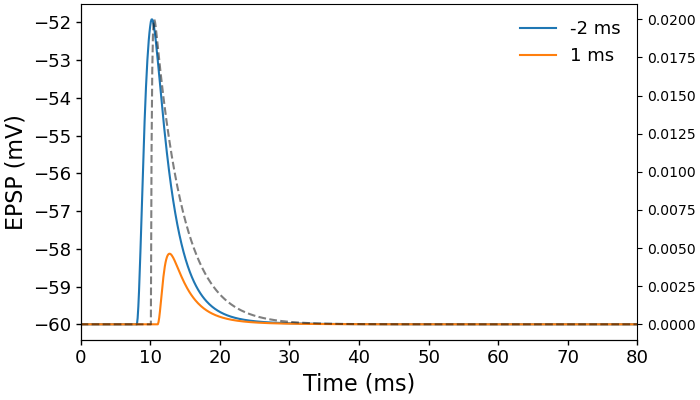

In [8]:
# show_idxs = [3, 11, 30]
show_idxs = [8, 11]
ff, aa = plt.subplots(1, figsize=(7, 4))
# aa.plot([i_time, i_time], [-60, np.max(v_rec)], c="black", linestyle="--", alpha=0.5)
aa_g = aa.twinx()
aa_g.plot(xaxis, syn_mats["i"]["g"][0], c="black", linestyle="--", alpha=0.5)
for i in show_idxs:
    aa.plot(xaxis, v_mat[i], label="%i ms" % (e_times[i] - i_time))

aa.set_xlim(0, 80)
aa.set_xlabel("Time (ms)", fontsize=16)
aa.set_ylabel("EPSP (mV)", fontsize=16)
aa.legend(frameon=False, fontsize=13)
clean_axes(aa, ticksize=13)
ff.set_layout_engine("compressed")

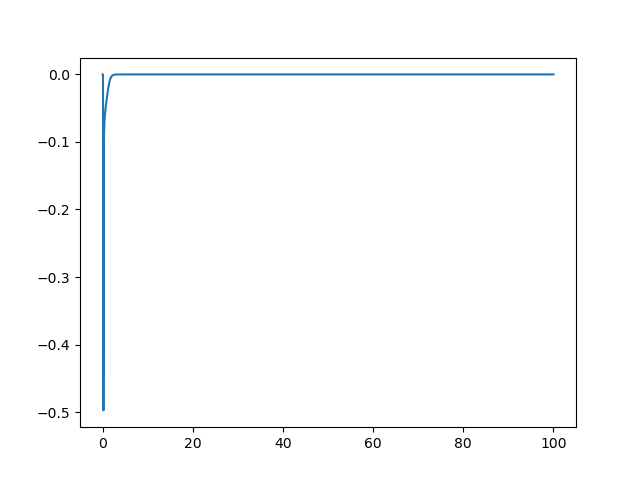

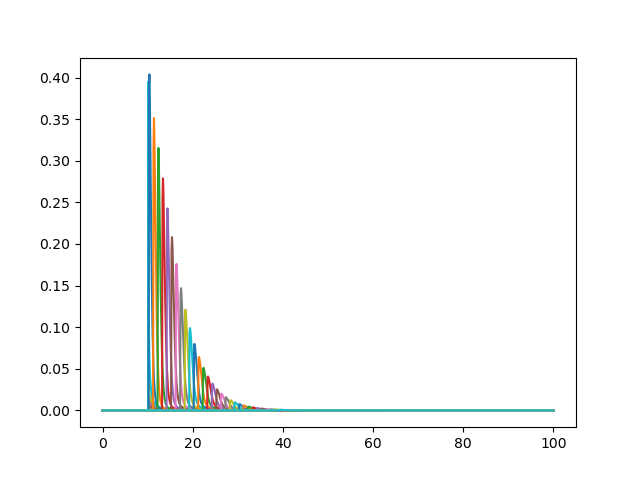

In [9]:
fff, aaa = plt.subplots(1)
for v in syn_mats["e"]["i"][:1]:
    aaa.plot(xaxis, v)
    
fffi, aaai = plt.subplots(1)
for v in syn_mats["i"]["i"]:
    aaai.plot(xaxis, v)

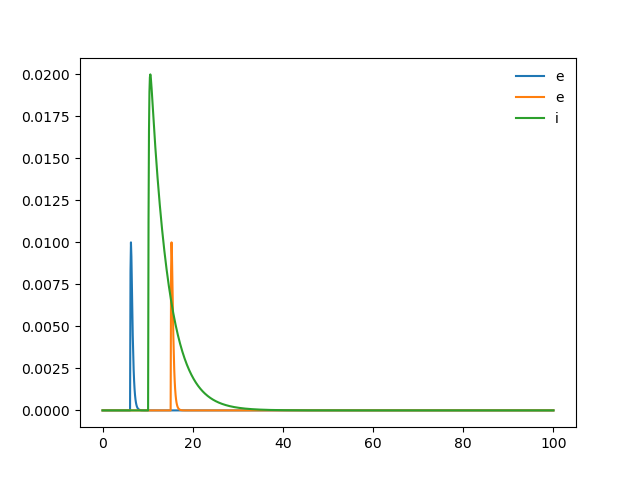

In [10]:
g_overlap_fig, g_overlap_ax = plt.subplots(1)
g_overlap_ax.plot(xaxis, syn_mats["e"]["g"][6], label="e")
g_overlap_ax.plot(xaxis, syn_mats["e"]["g"][15], label="e")
g_overlap_ax.plot(xaxis, syn_mats["i"]["g"][6], label="i")
g_overlap_ax.legend(frameon=False)

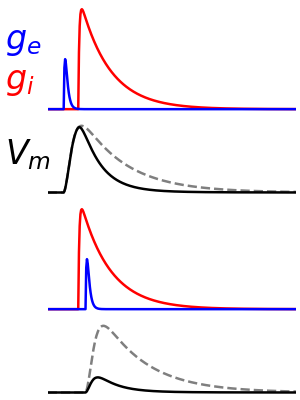

In [11]:
early_idx = 8
shunt_idx = 11

gspec = {"height_ratios": [0.3, 0.2, 0.3, 0.2]}
lw = 1.8
thesis_fig, thesis_ax = plt.subplots(4, 1, sharex=True, figsize=(3, 4), gridspec_kw=gspec)

thesis_ax[0].plot(xaxis, syn_mats["i"]["g"][early_idx], c="red", lw=lw)
thesis_ax[0].plot(xaxis, syn_mats["e"]["g"][early_idx], c="blue", lw=lw)
thesis_ax[1].plot(xaxis, v_mat_no_inh[early_idx], c="black", alpha=0.5, lw=lw, linestyle="--")
thesis_ax[1].plot(xaxis, v_mat[early_idx], c="black", lw=lw)
thesis_ax[2].plot(xaxis, syn_mats["i"]["g"][shunt_idx], c="red", lw=lw)
thesis_ax[2].plot(xaxis, syn_mats["e"]["g"][shunt_idx], c="blue", lw=lw)
thesis_ax[3].plot(xaxis, v_mat_no_inh[shunt_idx], c="black", alpha=0.5, lw=lw, linestyle="--")
thesis_ax[3].plot(xaxis, v_mat[shunt_idx], c="black", lw=lw)

thesis_ax[0].text(0, 0.012, "$g_e$", fontsize=24, c="blue")
thesis_ax[0].text(0, 0.004, "$g_i$", fontsize=24, c="red")
thesis_ax[1].text(0, -56.5, "$V_m$", fontsize=24, c="black")
thesis_ax[-1].set_xlim(6, 40)
for ax in thesis_ax:
    clean_axes(ax, remove_spines=["left", "right", "top", "bottom"])
    
thesis_fig.set_layout_engine("compressed")
thesis_fig.savefig(os.path.join(fig_path, "shunting_ex.svg"), bbox_inches="tight")